In [212]:
import math

import matplotlib.pyplot as plt
import numpy as np


def random_bloom_filter(l: int, k: int, p_flip: float = 0.0) -> np.ndarray:
    bf = np.zeros(l, dtype=int)
    bf[np.random.choice(l, size=k, replace=True)] = 1
    return bf


def flip_bloom_filter(bf: np.ndarray, p_flip: float) -> np.ndarray:
    return np.array([1 - x if np.random.random() < p_flip else x for x in bf])


def dice(a, b) -> float:
    a = np.array(a)
    b = np.array(b)
    return 2 * (a & b).sum() / (a.sum() + b.sum())


def jaccard(a, b) -> float:
    a, b = np.array(a), np.array(b)
    return (a & b).sum() / (a | b).sum()


assert dice([1, 1], [1, 1]) == 1.0
assert dice([0, 0], [1, 1]) == 0.0
assert dice([1, 0], [1, 0]) == 1.0
assert dice([1, 1], [1, 0]) == 0.6666666666666666
assert (
    dice(
        [1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
        [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
    )
    == 0.8333333333333334
)

# Helper functions to generate random bloom filters and calculate dice coefficient

def random_flip_dice(l, k, p_flip):
    bf = random_bloom_filter(l, k)
    a = flip_bloom_filter(bf, p_flip)
    b = flip_bloom_filter(bf, p_flip)
    return dice(a, b)

def random_dice(l, k):
    return dice(random_bloom_filter(l, k), random_bloom_filter(l, k))


# How similar are two random bloom filters depending on the chosen $k$?

We will take $l=500$ as a reference, and will check the similarity using the Dice coefficient for pairs of randomly generated bloom filters.

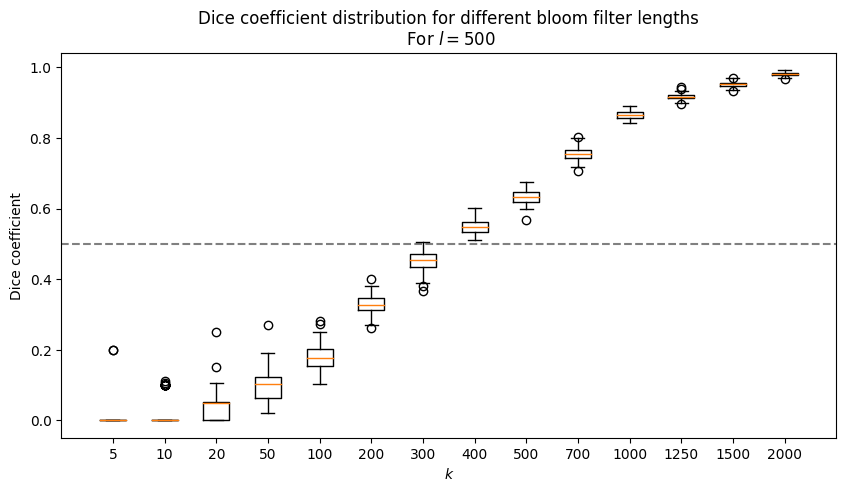

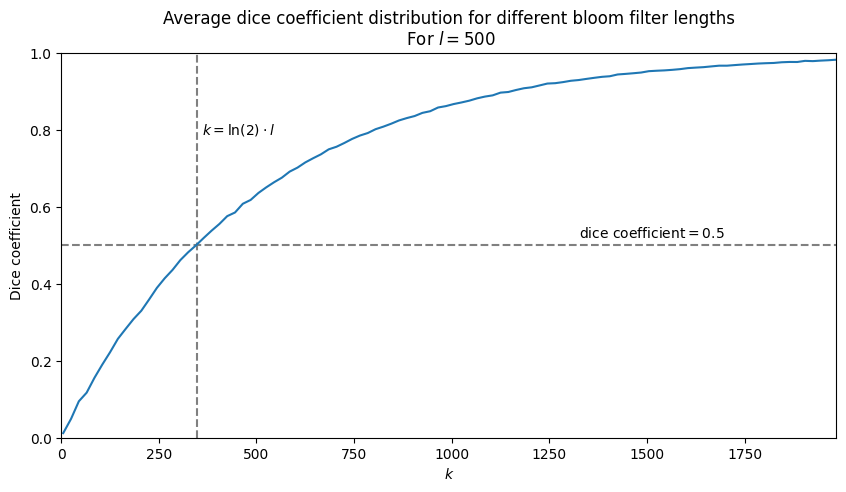

In [213]:
# Parameters
l = 500
N = 100
ks = [5, 10, 20, 50, 100, 200, 300, 400, 500, 700, 1000, 1250, 1500, 2000]

# Compute data
D = [[random_dice(l, k) for _ in range(N)] for k in ks]

# Plot
plt.figure(figsize=(10,5))
plt.title(f"Dice coefficient distribution for different bloom filter lengths\n For $l={l}$")
plt.ylabel("Dice coefficient")
plt.xlabel("$k$")
plt.xlim(0, len(ks)+1)
plt.hlines(0.5, 0, len(ks)+1, colors="gray", linestyles="dashed")
plt.boxplot(D, labels=ks)

# Compute data
ks = list(range(5, 2000, 20))
D = [[random_dice(l, k) for _ in range(N)] for k in ks]

plt.figure(figsize=(10,5))
plt.title(f"Average dice coefficient distribution for different bloom filter lengths\n For $l={l}$")
plt.ylabel("Dice coefficient")
plt.xlabel("$k$")
plt.xlim(0, ks[-1])
plt.ylim(0, 1)
plt.hlines(0.5, 0, ks[-1], colors="gray", linestyles="dashed")
plt.text(ks[len(ks)*2//3], 0.52, "dice coefficient$=0.5$")
plt.vlines(math.log(2)*l, 0, 1, colors="gray", linestyles="dashed")
plt.text(math.log(2)*l+15, 0.8, "$k = \ln(2) \cdot l$", verticalalignment="center")
plt.plot(ks, [np.mean(d) for d in D])
pass

#### Conclusions:

* For low $k$, bloom filters are *sparse*, and thus two random bloom filters are pretty dissimilar.
* The average similarity of $0.5$ is reached for $k=\ln{2}\cdot l$, where approximately half bits are 0 and half are 1.
* For larger $k$, bloom filters are *saturated* with ones, and thus are more similar to each other.

# How does the similarity coefficient vary for different bloom filter lengths?

We will take the reference $k$ value of $\ln(2)\cdot l$, and check the similarity distribution for different bloom filter lengths.

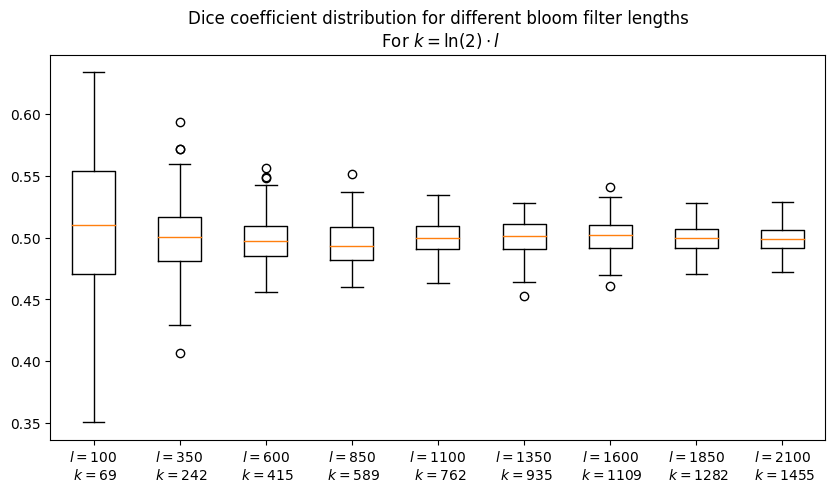

In [214]:
# Parameters
N = 100
ls = list(range(100, 2101, 250))

# Compute data
ks = [int(math.log(2) * l) for l in ls]
labels = [f"$l={l}$\n $k={k}$" for l, k in zip(ls, ks)]
D = [[random_dice(l, k) for _ in range(N)] for l, k in zip(ls, ks)]

# Plot
plt.figure(figsize=(10,5))
plt.title("Dice coefficient distribution for different bloom filter lengths\n For $k=\ln(2)\cdot l$")
plt.boxplot(D, labels=labels)
pass

#### Conclusion:

* Longer bloom filters narrow the range of similarities of two random bloom filters.

# What is the similarity of two bloom filters generated by randomly flipping bits of another reference bloom filter?

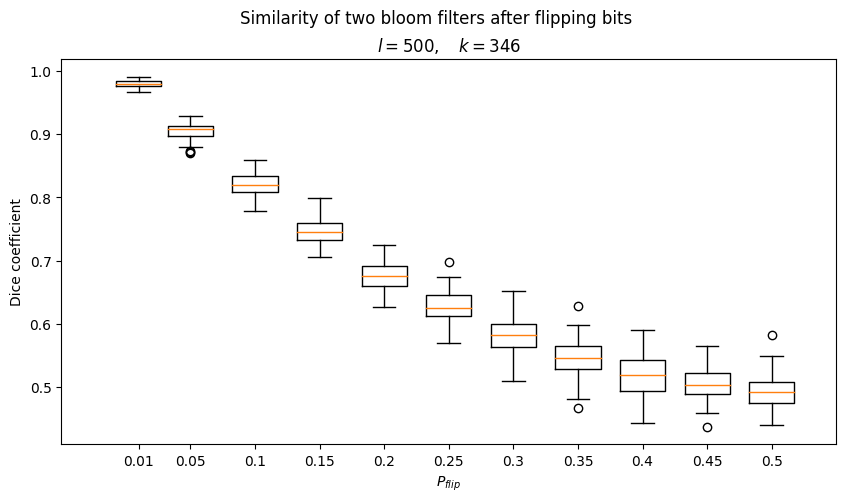

In [215]:
# Parameters
l = 500
k = 346
N = 100
ps_flip = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Compute data
D = [[random_flip_dice(l, k, p_flip) for _ in range(N)] for p_flip in ps_flip]

# Plot
plt.figure(figsize=(10,5))
plt.boxplot(D, positions=ps_flip, widths=0.035)
plt.xlim(-0.05, 0.55)
plt.suptitle("Similarity of two bloom filters after flipping bits")
plt.title(f"$l={l},\quad k={k}$")
plt.xlabel("$P_{flip}$")
plt.ylabel("Dice coefficient")
pass

## Conclusion

* Average similarity steadily decreases and is almost completely random for $p_{flip}>0.4$.

# Compare average similarity of two random bloom filters to similarity of two diffused bloom filters

$k$, the number of hash functions, also accounts for:
* The number of elements inserted in the bloom filter (q-grams, ranges, etc.)

Flipping probability can come from:
* Mispellings in the name that cause different q-grams.
* Differential privacy.

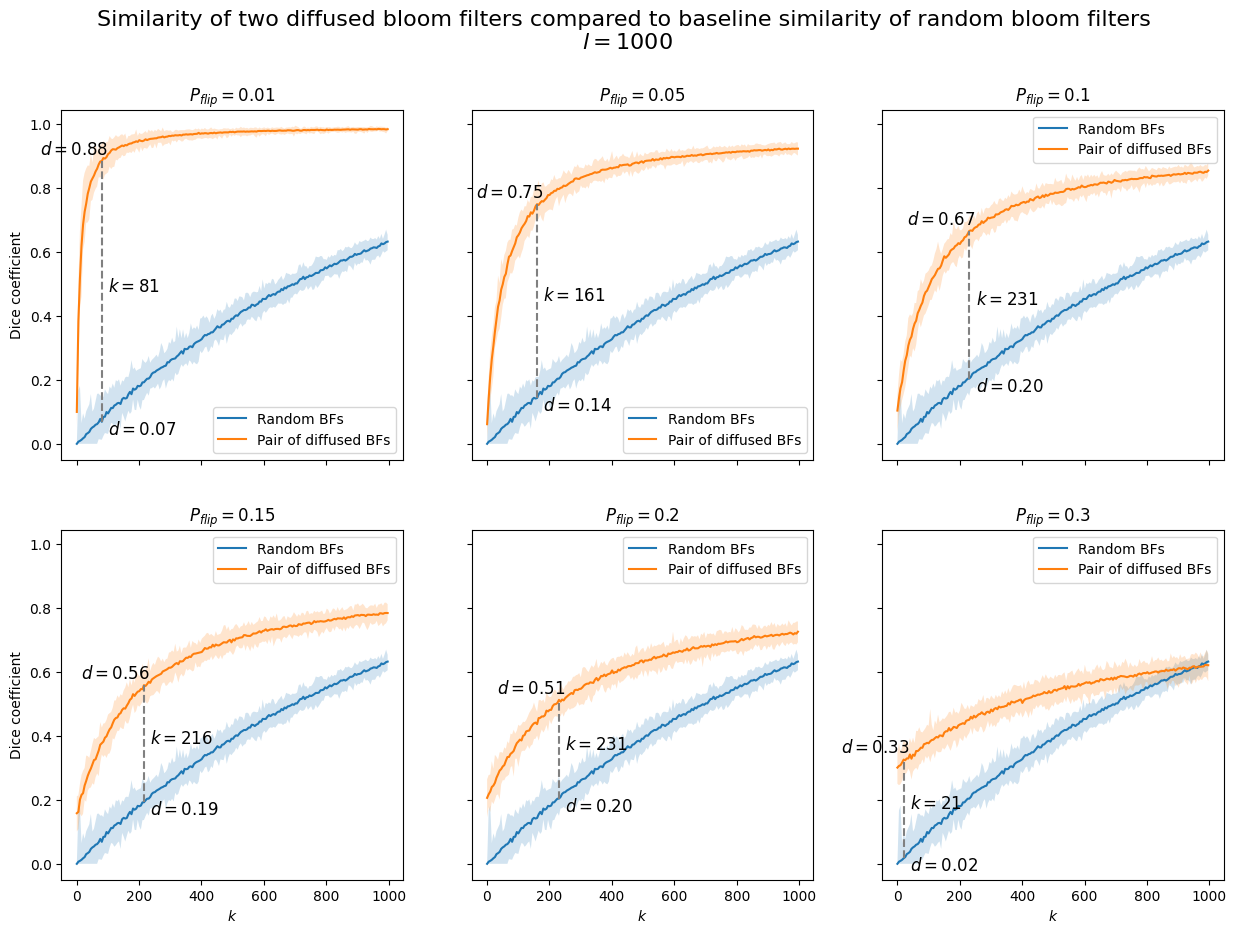

In [216]:

# Parameters
N = 50
l = 1000
ks = list(range(1, 1000, 5))
ps_flip = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3]

# Generate random bloom filters and compute their distances
random_bfs_dice = [np.array([random_dice(l, k) for _ in range(N)]) for k in ks]

# Compute the mean, min and max distance for each k
D_random = [ds.mean() for ds in random_bfs_dice]
D_random_min = [ds.min() for ds in random_bfs_dice]
D_random_max = [ds.max() for ds in random_bfs_dice]

# Configure plot
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(15, 10))
fig.suptitle(f"Similarity of two diffused bloom filters compared to baseline similarity of random bloom filters\n $l={l}$", fontsize=16)

# For each subplot
for i, p_flip in enumerate(ps_flip):
    # Comptue the distance of two diffused bloom filters
    D_pair, D_pair_low, D_pair_high = [], [], []
    max_difference, best_k, y0, y1 = 0.0, 0, 0, 0
    for d_random, k in zip(D_random, ks):
        d_pair = np.array([random_flip_dice(l, k, p_flip) for _ in range(N)])
        D_pair.append(d_pair.mean())
        D_pair_low.append(d_pair.min())
        D_pair_high.append(d_pair.max())

        # Find the k with the largest difference        
        if d_pair.mean() - d_random > max_difference:
            max_difference = d_pair.mean() - d_random
            best_k = k
            y0 = d_random
            y1 = d_pair.mean()

    # Plot
    ax = axs[i//3, i%3]
    ax.plot(ks, D_random, label="Random BFs")
    ax.plot(ks, D_pair, label="Pair of diffused BFs")
    ax.fill_between(ks, D_random_min, D_random_max, alpha=0.2)
    ax.fill_between(ks, D_pair_low, D_pair_high, alpha=0.2)
    ax.legend()
    ax.text(best_k+20, y1+0.02, f"$d={y1:.2f}$", fontsize=12, ha="right")
    ax.text(best_k+20, y0-0.04, f"$d={y0:.2f}$", fontsize=12)
    ax.vlines(x=best_k, ymin=y0, ymax=y1, color="gray", linestyle="dashed")
    ax.text(best_k+20, (y0+y1)/2, f"$k={best_k}$", fontsize=12)
    ax.set_title(f"$P_{{flip}}={p_flip}$")
    if i >= 3:
        ax.set_xlabel("$k$")
    if i % 3 == 0:
        ax.set_ylabel("Dice coefficient")

## Conclusion
* It is very important to choose the right $k$ depending on the flipping probability.
* We can use these plots to decide how many hash functions to use, how much differential privacy, and what kind of expansions to do.

# Differential privacy

In [217]:
# Calculate flip probability for different epsilons

for eps in range(1, 11):
    p_flip = 1.0 / (1.0 + math.exp(eps))
    print(f"eps={eps}, p_flip={p_flip:.5f}")

eps=1, p_flip=0.26894
eps=2, p_flip=0.11920
eps=3, p_flip=0.04743
eps=4, p_flip=0.01799
eps=5, p_flip=0.00669
eps=6, p_flip=0.00247
eps=7, p_flip=0.00091
eps=8, p_flip=0.00034
eps=9, p_flip=0.00012
eps=10, p_flip=0.00005


# Next steps

## Define a protocol to tokenize each field separately

* First name
* Last name
* City
* Date of birth
* ID (passport, social security number)

Things to investigate:
* [Soundex](https://en.wikipedia.org/wiki/Soundex)

## Find a way to evaluate tokenization and linkage together, separately for each field

1. Collect 3 datasets: will all correct data, with some errors and with many errors.
2. Tokenize all records.
3. Plot the similarity of same vs different records.

Question: can we define a threshold? We may need to tweak the tokenization in order to get an optimal one.

4. Define a way to link records: could be via the threshold, could be via clustering or other means.
5. Compute a metric of how good the linkage is.

## Tokenize and link using all different fields.

Compute similarity score for each separate field.

Define a protocol to link full records together.

